In [74]:
from sqlalchemy.engine import create_engine, URL
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

In [75]:
SERVER = 'localhost'  # localhost innebär att du ansluter till en server på din egen dator
DATABASE = 'AdventureWorks2022'

connection_string = f'DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};Trusted_Connection=yes;Encrypt=no'

connection_url = URL.create('mssql+pyodbc', query={'odbc_connect': connection_string})

engine = create_engine(connection_url)  # engine är anslutningsobjektet vi använder för att kommunicera med databasen.

## Svar på Teoretiska Frågor

 
 1. Beskriv kort hur en relationsdatabas fungerar.  
 SVAR: 
         I en relationsdatabas är data lagrad i tabeller som består av rader och kolumner. Mellan tabellerna finns det relationer som kan kopplas samman för att skapa nya tabeller där utvalda uträkningar kan göras i nya kolumner.

 2. Vad menas med “CRUD”-flödet?  
 SVAR: CRUD är en akronym som står för:
        Create-moments. Rader läggs till i en tabell.
        Read-moments. Data utläses från tabeller.
        Update-moments. Uppdatering av redan skapade och lagrade tabeller.
        Delete-moments. Rader eller hela tabeller tas bort.

 3. Beskriv kort vad en “left join” och en “inner join” är. Varför använder man det?  
 SVAR: 
        Tabellen som anges efter FROM är den vänstra tabellen. Så när vi gör en left join hämtas all information från den tabellen samt matchande rader från den andra tabellen som vi gör en left join med.
        När vi gör en inner join hämtas enbart matchande rader från båda tabeller.

 4. Beskriv kort vad indexering i SQL innebär.  
 SVAR: 
         Indexering används för att skapa en struktur vilket gör det lättare för systemet att hitta de värden i våra tabeller som vi söker. Databasen söker i de index vi skapat istället för att söka igenom varje rad i hela tabellen. Det finns en del olika typer av index som väljs beroende på vad som lagras och hur informationen ska användas. Indexering gör databasen snabbare att läsa men kan medföra högre resursanvändning vid uppdateringar. Det är en balans mellan prestanda och lagringsutrymme.

 5. Beskriv kort vad en vy i SQL är.  
 SVAR: En vy är en virtuell tabell som skapas med en query. Den visar tabellen utan att spara den. En vy kan bland annat delas med individer som inte har tillgång till informationen eller tabellerna i databasen. 

 6. Beskriv kort vad en lagrad procedur i SQL är.  
 SVAR: En lagrad procedur är en qurey som sparas i databasen och kan återanvändas. Den säkerställer att flera användare får konsistenta resultat. Den lagrade proceduren fungerar som en funktion som kan ta emot parametrar, utföra operationer och retunera resultat.

## Deskriptiv sammanfattning av Databasen Adenture Works 2022

Databasen Adventure Works 2022 är en databas över ett online-företag som säljer cyklar samt tillbehör. Databasen är väl uppbyggd och ger tydlig information om företagets processer inom försäljning, personal, ekonomi och produktion. Den är uppdelad i följande scheman som i sin tur har flera undertabeller;  
  
•	Human Resources: Innehåller information om företagets anställda, såsom löner, anställningstid, kön och adress.  
•	Person: Visar information om ”stakeholders”. Alltså individer som interagerar med företaget. Exempel är anställda, leverantörer samt kunder.  
•	Production: Innehåller information om företagets produkter. Exempel är produktbilder, lagerstatus, samt enskild produktinformation.  
•	Purchasing: Innehåller bland annat, information om företagets inköp, inköpsordrar samt leverantörer.  
•	Sales: Innehåller all information om företagets försäljning. Ett par exempel är geografisk försäljning, enskilda säljares försäljning, produkters försäljningspris, kunddata och olika försäljningstransaktion.  
  
Nedan visualiseras en bild på Adventure Works försäljning per kategori. Vilket är en av aspekterna jag valt att fokusera på i denna kunskapskontroll.  
 Eftersom engelska används i databasen samt används inom många stora företag kommer resterande presentation om Adventure Works att göras på engelska.


In [76]:
query = '''SELECT 
	PC.Name AS Category,
	SUM(SOD.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail AS SOD
	INNER JOIN Production.Product AS PP
		ON SOD.ProductID = PP.ProductID
	INNER JOIN Production.ProductSubcategory AS PS
		ON PP.ProductSubcategoryID = PS.ProductSubcategoryID
	INNER JOIN Production.ProductCategory AS PC
		ON PC.ProductCategoryID = PS.ProductCategoryID
GROUP BY PC.Name
;'''

CategorysVis_df = pd.read_sql(query,engine)

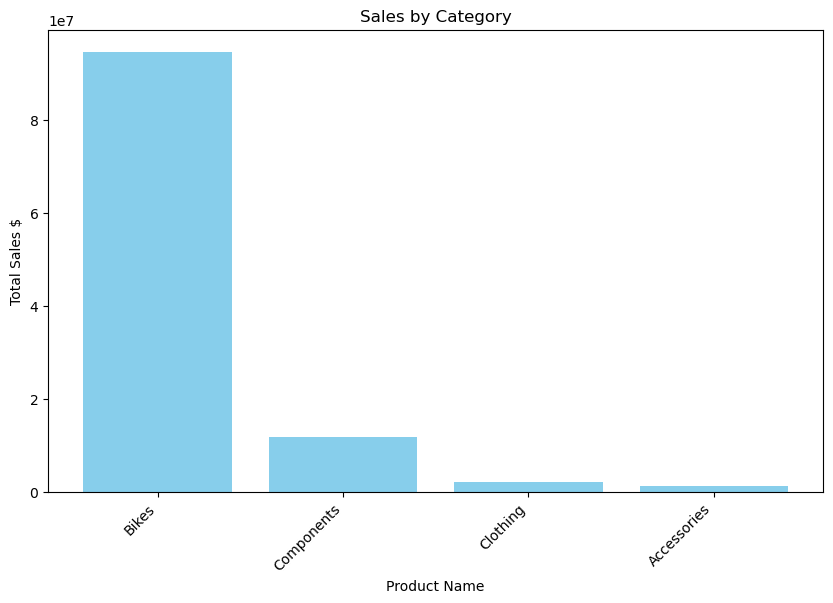

In [89]:
Sales_per_category = CategorysVis_df.sort_values(by='TotalSales', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(Sales_per_category['Category'], Sales_per_category['TotalSales'], color='skyblue')
plt.xlabel('Product Name')
plt.ylabel('Total Sales $')
plt.title('Sales by Category')
plt.xticks(rotation=45, ha='right')
plt.show()

## Top 10 Most Sold Products

In [78]:
query = '''SELECT 
	PP.Name AS ProductName,
	PO.UnitPrice AS PurchaseUnitPrice,
	SO.UnitPrice AS SalesPrice,
	SUM(SO.OrderQty) AS SalesOrderQty,
	SUM(SO.UnitPrice * SO.OrderQty) - SUM(PO.UnitPrice * SO.OrderQty) AS Result
FROM Sales.SalesOrderDetail AS SO
	INNER JOIN Purchasing.PurchaseOrderDetail AS PO
	ON SO.ProductID = PO.ProductID
	INNER JOIN Production.Product AS PP
	ON SO.ProductID = PP.ProductID
WHERE SO.UnitPrice > PO.UnitPrice
GROUP BY PP.Name,
		PO.UnitPrice,
		SO.UnitPrice
ORDER BY SalesOrderQty DESC, Result DESC
;'''

SoldProfitableProducts_df = pd.read_sql(query, engine)

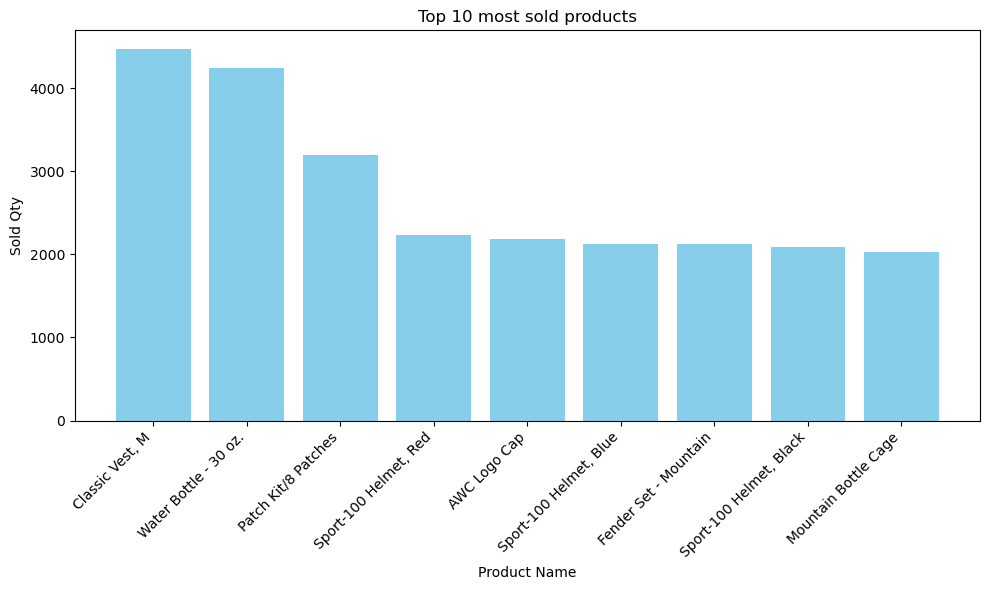

In [79]:
top10_products = SoldProfitableProducts_df.sort_values(by='SalesOrderQty', ascending=False,).head(10)

plt.figure(figsize=(10,6))
plt.bar(top10_products['ProductName'], top10_products['SalesOrderQty'], color= 'skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 most sold products')
plt.xlabel('Product Name')
plt.ylabel('Sold Qty')
plt.tight_layout()

plt.show()


## Top 10 most profitable products. Based on purchase price, sales price and quantity.

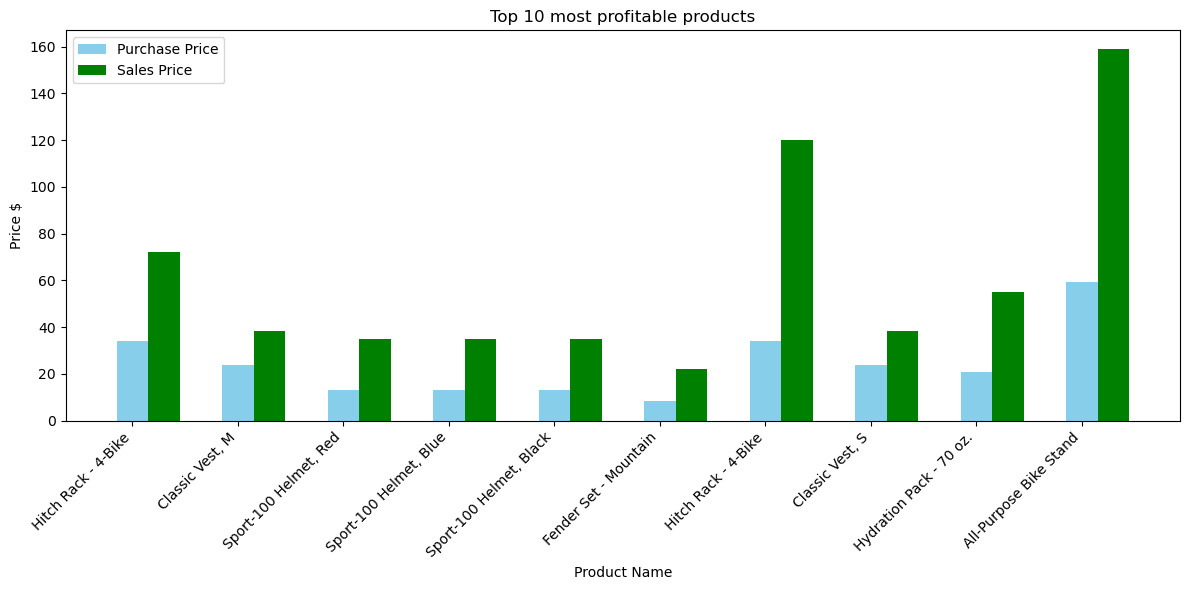

In [93]:
top10_products = SoldProfitableProducts_df.sort_values(by='Result', ascending=False,).head(10)

x = np.arange(len(top10_products))
width = 0.3

plt.figure(figsize=(12, 6))

plt.bar(x, top10_products['PurchaseUnitPrice'], width=width, label='Purchase Price', color='skyblue')
plt.bar(x + width, top10_products['SalesPrice'], width=width, label='Sales Price', color='green')

plt.xticks(x, top10_products['ProductName'], rotation=45, ha='right')

plt.title('Top 10 most profitable products')
plt.xlabel('Product Name')
plt.ylabel('Price $')
plt.legend()
plt.tight_layout()

plt.show()

## Result

The first chart highlights the sales volume of the top 10 products while the second chart highlights profit margins per product on the top 10 most profitable products, ordered by sales volume. Together they provide information on which products sell the most and which yield the highest profit per unit.

## Analysis of the result: 

The most sold products are not always the ones with the best margins. The company can work on securing better deals with suppliers by leveraging large volumes during negotiations. For example, "Classic Vest, M," the best-selling item, presents an opportunity for Adventure Works to negotiate a lower purchasing price.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Preto-analysis

Pareto is a tool that highlights, in this case, Adventure Works key contributors to their overall outcome. It is alligned with the 80/20 rule. Which suggests that approximatly 80%
of the result come from 20% of the causes. This can be a powerful tool in order to understand in which areas to put extra resurces or which product or services to cut.

### Pareto- Overall View

The Pareto analysis in this chart is used to identify the top products that account for approximately 80% of the company’s outcome. The red line shows the cumulative percentage that each product contributes to. As seen in the chart, a minority of products contribute to the majority of AdventureWorks' total outcome, allowing for better prioritization and resource allocation within the company.

In [81]:
query = '''WITH ProductResluts AS (
	SELECT 
		PP.Name AS ProductName,
		PO.UnitPrice AS PurchaseUnitPrice,
		SO.UnitPrice AS SalesPrice,
		SUM(SO.OrderQty) AS SalesOrderQty,
		SUM(SO.UnitPrice * SO.OrderQty) - SUM(PO.UnitPrice * SO.OrderQty) AS Result
FROM Sales.SalesOrderDetail AS SO
		INNER JOIN Purchasing.PurchaseOrderDetail AS PO
		ON SO.ProductID = PO.ProductID
		INNER JOIN Production.Product AS PP
		ON SO.ProductID = PP.ProductID
WHERE SO.UnitPrice > PO.UnitPrice -- Tar bort alla produkter som säljes med förlust.
GROUP BY PP.Name,
		PO.UnitPrice,
		SO.UnitPrice
),
--CTE 
ParetoData AS (
	SELECT
		ProductName,
		PurchaseUnitPrice,
		SalesPrice,
		SalesOrderQty,
		Result,
		SUM(Result) OVER (ORDER BY Result DESC) AS CummulativeResult,
		SUM(Result) OVER() AS TotalResult
	FROM ProductResluts
	)
SELECT
	ProductName,
	PurchaseUnitPrice,
	SalesPrice,
	SalesOrderQty,
	Result,
	CummulativeResult,
	CummulativeResult *100 /TotalResult AS ParetoPercent
FROM ParetoData
ORDER BY ParetoPercent DESC
;
;'''

paretodata_df = pd.read_sql(query, engine)

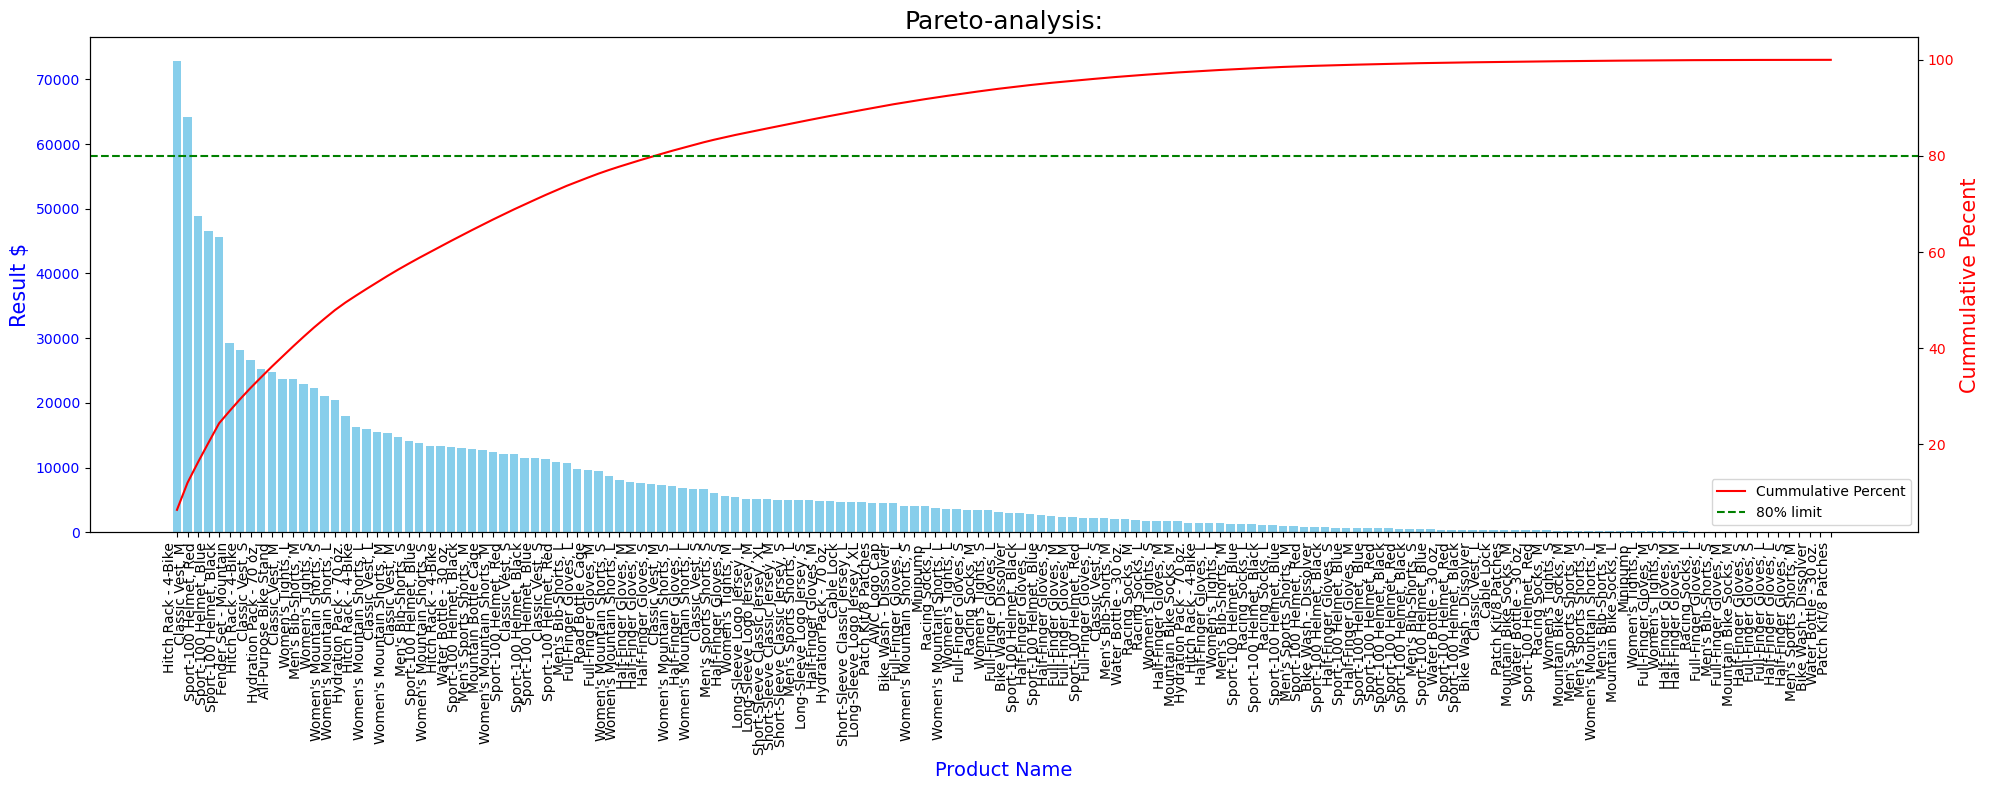

In [98]:
paretodata_df = paretodata_df.sort_values(by='Result', ascending=False)

x = np.arange(len(paretodata_df))

fig, ax1 = plt.subplots(figsize=(20, 8))
ax1.bar(x, paretodata_df['Result'], color='skyblue', label='Result')
ax1.set_xlabel('Product Name', fontsize=14, color='blue')
ax1.set_ylabel('Result $', fontsize=15, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(x, paretodata_df['ProductName'], rotation=90, ha='right')

ax2 = ax1.twinx()
ax2.plot(x, paretodata_df['ParetoPercent'], color='red', label='Cummulative Percent')
ax2.axhline(80, color='green', linestyle='--', label='80% limit')
ax2.set_ylabel('Cummulative Pecent', fontsize=15, color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Pareto-analysis:', fontsize=18)
fig.tight_layout()
plt.legend(loc='lower right')
plt.show()

### Pareto- "Top 20% Products"

This diagram puts focus on the top products.  

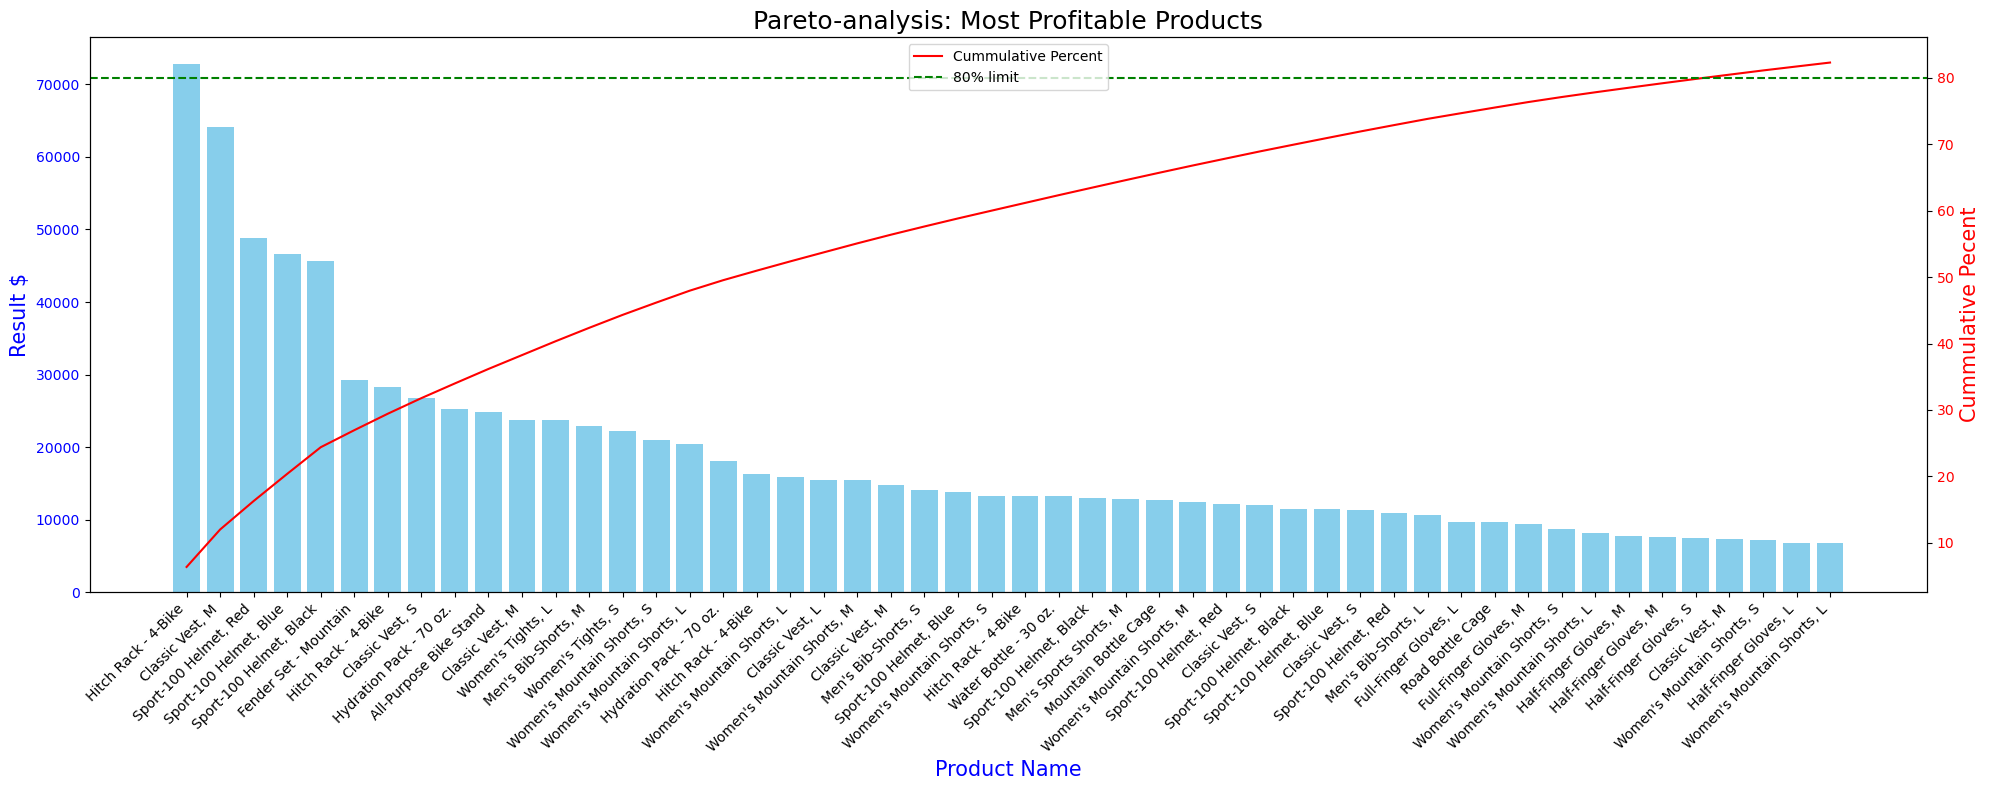

In [100]:
paretodata_df = paretodata_df.sort_values(by='Result', ascending=False)
top_products = paretodata_df.head(50)

x = np.arange(len(top_products))

fig, ax1 = plt.subplots(figsize=(20, 8))
ax1.bar(x, top_products['Result'], color='skyblue', label='Resultat')
ax1.set_xlabel('Product Name', fontsize=15, color='blue')
ax1.set_ylabel('Result $', fontsize=15, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(x, top_products['ProductName'], rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(x, top_products['ParetoPercent'], color='red', label='Cummulative Percent')
ax2.axhline(80, color='green', linestyle='--', label='80% limit')
ax2.set_ylabel('Cummulative Pecent', fontsize=15, color='red')

ax2.tick_params(axis='y', labelcolor='red')

plt.title('Pareto-analysis: Most Profitable Products', fontsize=18)
fig.tight_layout()
plt.legend(loc='upper center')
plt.show()

## Result

This Pareto analysis shows that a small percentage of the company’s products does account for the majority of the overall result. The first products on the x-axis contribute to roughly 80% of the total result, while the remaining products have a lower individual contribution. The cumulative percentage (the red line) indicates how the results accumulate, while the green line marks the 80% limit.

## Analysis of Pareto result

For this analysis, products sold at a loss have been excluded. It is acknowledged that some products are intentionally sold at a negative profit as part of a strategic approach. An example could be that certain products must be purchased alongside complementary items with high margins, which offset the negative results from the loss-leading products. These aspects will not be considered in this analysis due to time constraints; however, they are acknowledged by the author.  

With the top products identified, Adventure Works can make decisions on resource allocation. Having products in stock that do not yield much profit can turn into a negative result when the cost of having it in stock is taken into consideration. Products that have a lower impact on the company (products below the 80% limit) could be less prioritized or removed from sales assortment. Another approach could be to give certain products more resources for marketing to make it above the 80% limit.
 

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Confidence Interval

### All products

In [84]:
Results = paretodata_df['Result']

mean_results = np.mean(Results)
std_results = np.std(Results, ddof=1)
n = len(Results)

z = 1.96
lower_ci = mean_results - z *(std_results / np.sqrt(n))
upper_ci = mean_results + z *(std_results / np.sqrt(n))

print(f'Mean-result: {mean_results}')
print(f'95% Confidence Interval: {lower_ci}, {upper_ci}')

Mean-result: 7213.312601898733
95% Confidence Interval: 5451.9530555938145, 8974.672148203652


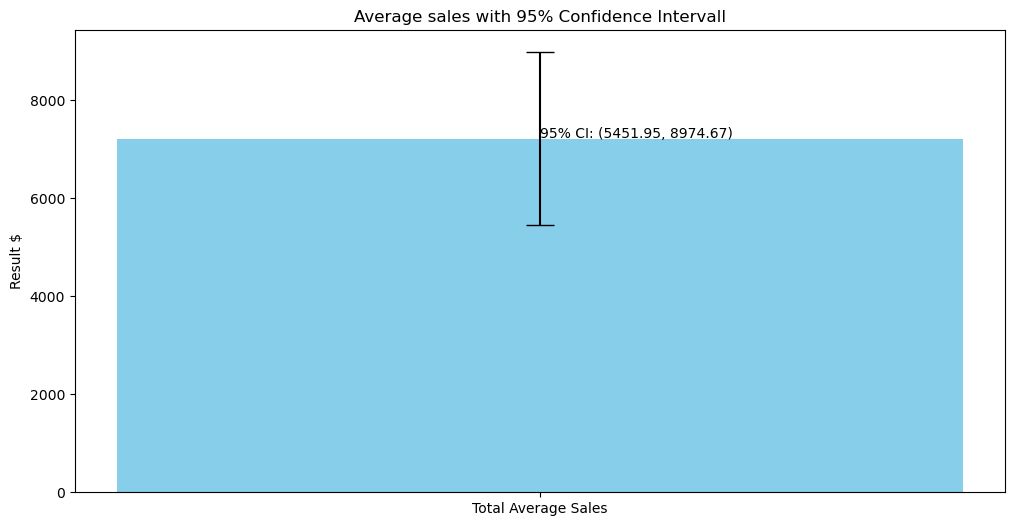

In [85]:
plt.figure(figsize=(12, 6))
plt.bar('Total Average Sales', mean_results, color='skyblue', yerr=[[mean_results - lower_ci], [upper_ci - mean_results]], capsize=10)

plt.ylabel('Result $')
plt.title('Average sales with 95% Confidence Intervall')
plt.text(0, mean_results + 20, f'95% CI: ({lower_ci:.2f}, {upper_ci:.2f})', ha='left')
plt.tight_layout
plt.show()

## Result

This bar chart illustrates the total average sales along with the 95% confidence interval. No analysis has been made for this chart due to the wide variation in product prices within the assortment. Confidence Interval per product category is presented below.

## Confidence Interval per Category

In [86]:
query = '''SELECT 
	PC.Name AS Category,
	SUM(SOD.LineTotal) AS TotalSales,
	COUNT(SOD.SalesOrderDetailID) AS NTransaktions,
	AVG(SOD.LineTotal) AS AvgSales,
	STDEV(SOD.LineTotal) AS StdvSales
FROM Sales.SalesOrderDetail AS SOD
	INNER JOIN Production.Product AS PP
		ON SOD.ProductID = PP.ProductID
	INNER JOIN Production.ProductSubcategory AS PS
		ON PP.ProductSubcategoryID = PS.ProductSubcategoryID
	INNER JOIN Production.ProductCategory AS PC
		ON PC.ProductCategoryID = PS.ProductCategoryID
GROUP BY PC.Name
;'''

ci_data_df = pd.read_sql(query,engine)

In [87]:
ci_data_df['LowerCI'] = ci_data_df['AvgSales'] - z * (ci_data_df['StdvSales'] / np.sqrt(ci_data_df['NTransaktions']))
ci_data_df['UpperCI'] = ci_data_df['AvgSales'] + z * (ci_data_df['StdvSales'] / np.sqrt(ci_data_df['NTransaktions']))

print(ci_data_df[['Category','AvgSales', 'LowerCI', 'UpperCI']])

      Category     AvgSales      LowerCI      UpperCI
0     Clothing    99.118562    97.523711   100.713413
1        Bikes  2364.446871  2342.391063  2386.502679
2  Accessories    30.880052    30.267000    31.493104
3   Components   631.222231   619.515536   642.928926


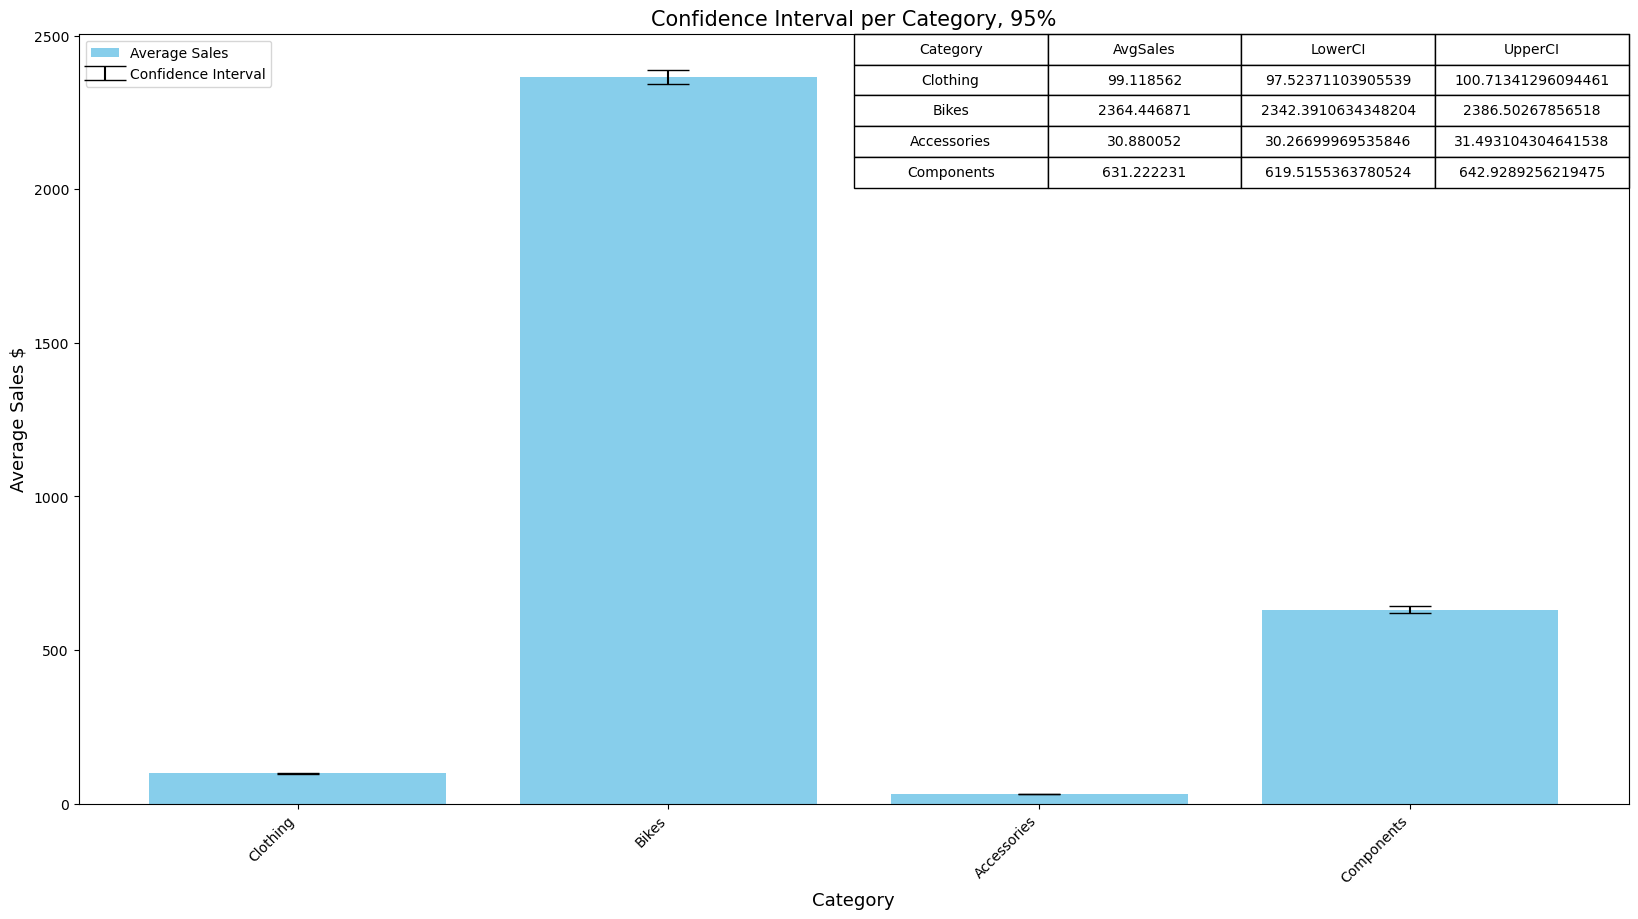

In [88]:
plt.figure(figsize=(20, 10))
plt.bar(ci_data_df['Category'], ci_data_df['AvgSales'], color='skyblue', label='Average Sales')
plt.errorbar( ci_data_df['Category'] ,ci_data_df['AvgSales'], 
             yerr=[ci_data_df['AvgSales'] - ci_data_df['LowerCI'], 
                   ci_data_df['UpperCI'] - ci_data_df['AvgSales']], fmt='none',color='black', capsize=15, label='Confidence Interval')

table_data = ci_data_df[['Category', 'AvgSales', 'LowerCI', 'UpperCI']]
table = plt.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center',
                  loc='upper right',
                  bbox=[0.5, 0.8, 0.5, 0.2]
                  
                  )

plt.title('Confidence Interval per Category, 95%', fontsize=15)
plt.xlabel('Category', fontsize=13)
plt.ylabel('Average Sales $', fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.legend (loc='upper left')

plt.show()


## Result

The chart shows the average sales represented by the hight of the bar. The vertical line extending above and below the bar is the corresponding confidence interval, indicating the range where the result of the sales is expected be 95% of the time.  
The Bike category significantly outperforms the other categories, which is to be expected. The confidence interval in each category is narrow according to the chart.

## Analysis

The narrow confidence interval in all categories suggests a low uncertainty in sales performance. Indicating a stable demand and predictable results. 

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Executive Summary

The most sold products are not always the ones with the best margins. Adventure Works can work on securing better deals with suppliers by leveraging large volumes during negotiations.
Optimization of resource allocation by prioritizing profitable products, potentially reducing or removing low-profit products from stock, i.e. products that fall below the 80% impact threshold. Alternatively underperforming products that are vital and considered a “must have” in assortment yet falls under the threshold can be prioritized by improved marketing to increase sales.  
The narrow confidence interval in all categories suggests a low uncertainty in sales performance. Indicating a stable demand and predictable results. 


-------------------------------------------------------------------------------------------------------

## Självvärdering

 1. Utmaningar du haft under arbetet samt hur du hanterat dem.  
 -- Kodningen har varit utmanande. Jag har gjort kurser i både DataCamp och LinkedIn. Känner mig fortfarande väldigt mycket som en nybörjare. Mitt sätt att hantera denna frustration är att påminna mig om att det är en inlärningsprocess som tar tid.  

 2. Vilket betyg du anser att du skall ha och varför.  
 -- Det har jag inte tillräcklig kunskap om än för att svara på.  

 3. Tips du hade gett till dig själv i början av kursen nu när du slutfört den.  
-- Eventuellt att skriva en mer detaljerad struktur på vad jag ville ta reda på innan jag började.  

### Tid för muntlig presentation: 3 januari 2025